In [322]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3 [40 points]   
● Download the imagenet collection from http://image-net.org/. The imagenet collection is very big for the scope of the class. We will pick few categories so that we can keep the computations tractable. As you can see http://image-net.org/explore the categories are not balanced. For the scope of this class we will use the images from:  
* Plant, flora, plant life  (1271)   
* Geologicalformation (1808)   
* Fungus  (1207)  
* Sport  (1888)  
* Person  (1242)  
* Animal  (1571)  

● Convert the images to vectors:  
   1. Autoencoder (unsupervised): You can pick your model details, but justify them (loosely)  
   2. Singular Value Decomposition: Represent each image as a vector by unfolding it columnwise. If you have N images, and each image is 256 x 256 that will give you a matrix of N x 2^16. You can do SVD on that matrix and transform each image as a k dimensional vector. You may choose to resample images to be uniform size beforehand. You can pick the number of singular values to retain (k), but provide a justification.  
   3. Histograms: For every image,  
    i. Create RGB histograms and combine to create a single feature vector by concatenating RGB vectors.  
    ii. Create HSV histograms and combine to create a single feature vector by concatenating HSV vectors.

In [383]:
from keras.preprocessing import image

In [384]:
#normalize the scale of color to 0-1 range
train_datagen = image.ImageDataGenerator(rescale=1./255)

In [391]:
#the size will be compressed to 128*128 to reduce the computation time
#class_label will be single number of [0-5]
train_generator = train_datagen.flow_from_directory(
        'train',
        class_mode = 'binary',
        target_size=(128, 128),
        batch_size = 100,
        shuffle = True)

Found 8987 images belonging to 6 classes.


In [392]:
batches = 0
#it will have 9000 imgs (with 20ish duplicates) as the generator send 100 pics per batch
All_img = []
labels = []

for X_batch, Y_batch in train_generator:
    batches +=1
    All_img.append(X_batch)
    labels.append(Y_batch.astype(int))
    if batches >= 90:
        break

In [394]:
X_raw = np.concatenate(All_img, axis=0)
Y_raw = np.concatenate(labels, axis=0)
#split the data into test set and training set by 20%~80%
train_index = np.random.choice(len(X_raw), int(len(X_raw)*0.8), replace=False)
test_index = np.delete(np.arange(len(X_raw)), train_index,axis = 0)

X_train_raw = X_raw[train_index]
X_test_raw = X_raw[test_index]

Y_train_raw = Y_raw[train_index]
Y_test_raw = Y_raw[test_index]

In [395]:
#set up the auto encoder 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.losses import mean_squared_error
from keras.callbacks import TensorBoard,History

#helper function to plot each image
def plot_imgs(decoded_imgs, x_test):
    n = 10  # how many images we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(128, 128, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [396]:
#set up auto encoders, using the changing size of filters as it performed best in problem 2
#use 3 cov_layer with encoded vector with reasonable size as 32*32*4
input_img = Input(shape=(128, 128, 3))

x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded  = Conv2D(3, (5, 5), activation='relu',padding='same')(x)

In [1]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adagrad',loss='binary_crossentropy',metrics=['mse'])

NameError: name 'Model' is not defined

In [400]:
#train the auto encoder 
autoencoder.fit(X_train_raw,X_train_raw, epochs=10,batch_size = 64,shuffle=True,
                validation_data=(X_test_raw, X_test_raw))

Train on 7189 samples, validate on 1798 samples
Epoch 1/10
7189/7189 [==============================] - 400s - loss: 0.7460 - mean_squared_error: 0.0624 - val_loss: 0.5963 - val_mean_squared_error: 0.0358
Epoch 2/10
7189/7189 [==============================] - 369s - loss: 0.5889 - mean_squared_error: 0.0328 - val_loss: 0.5831 - val_mean_squared_error: 0.0304
Epoch 3/10
7189/7189 [==============================] - 332s - loss: 0.5800 - mean_squared_error: 0.0292 - val_loss: 0.5784 - val_mean_squared_error: 0.0282
Epoch 4/10
7189/7189 [==============================] - 334s - loss: 0.5747 - mean_squared_error: 0.0271 - val_loss: 0.5761 - val_mean_squared_error: 0.0278
Epoch 5/10
7189/7189 [==============================] - 342s - loss: 0.5718 - mean_squared_error: 0.0261 - val_loss: 0.5704 - val_mean_squared_error: 0.0254
Epoch 6/10
7189/7189 [==============================] - 334s - loss: 0.5690 - mean_squared_error: 0.0251 - val_loss: 0.5678 - val_mean_squared_error: 0.0245
Epoch 7/10

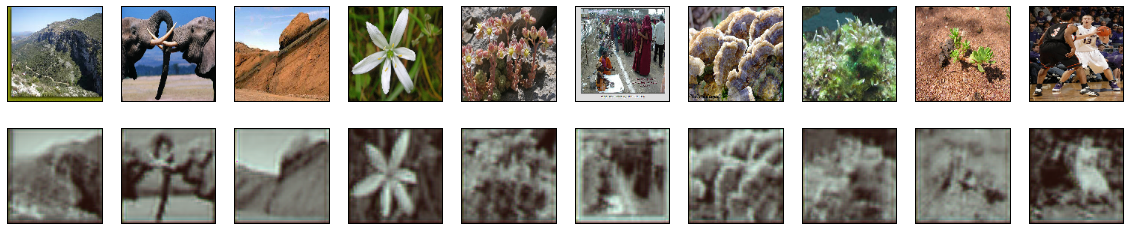

In [401]:
decoded_imgs = autoencoder.predict(X_test_raw)
plot_imgs(decoded_imgs, X_test_raw)

In [402]:
encoder = Model(input_img, encoded)
X_autoencoder = encoder.predict(X_raw)

In [405]:
X_autoencoder = X_autoencoder.reshape(len(X_raw), 32*32*4)

In [406]:
#svd. choose 70 to be k as the variance explained increases very slow with k as k > 70
from sklearn.decomposition import TruncatedSVD
svd_matrix = X_raw.reshape(X_raw.shape[0], 128*128*3)
svd = TruncatedSVD(n_components = 70)
X_svd = svd.fit_transform(svd_matrix)

In [412]:
#hist rgb, hsv
from skimage.color import rgb2hsv

img_hist_rgb = []
img_hist_hsv = []

def img_to_vec(img):
    #input image array [:,:,3] output vector hist [768,]
    img_hist = []
    for i in range(3):
        vector = img[:,:,i].reshape(128*128)
        hist,_ = np.histogram(vector, 256)
        img_hist.append(hist)
    vector_hist = np.concatenate(img_hist)
    return vector_hist

for img in X_raw:
    #convert image from rgb to hsv format
    img_hsv = rgb2hsv(img)
    vec_rgb = img_to_vec(img)
    vec_hsv = img_to_vec(img_hsv)
    
    img_hist_rgb.append(vec_rgb)
    img_hist_hsv.append(vec_hsv)
    
X_hist_rgb= np.vstack(img_hist_rgb)
X_hist_hsv= np.vstack(img_hist_hsv)

● Compare classification results. Each of the four techniques in #2 above convert images into a vector. For each of the four techniques:   
1. Use Euclidean distance and Pearson correlation coefficient to find the 5
nearest neighbors of each image.
2. Use majority vote of the 5 NNs to determine the category of each image.
3. Create a 6x6 confusion matrix for each distance metric whose rows index
the true categories and whose columns index the predicted category values. Compute counts for each cell, and the overall accuracy of the system (percentage of correctly classified images).


In [413]:
from sklearn.metrics.pairwise import pairwise_distances

def predict_knn_test(X, dist = "eu"):
    #take the entire corpus, generate predictions labels for the test set
    #input: array(8987, x), dist = "eu" for euclidean and "cor" for correlation
    #return: array(8987*0.2,)
    
    
    X_train = X[train_index]
    X_test = X[test_index]
    if dist == "eu":
        distances = pairwise_distances(X_test, X_train)
    elif dist == "cor":
        distances = pairwise_distances(X_test, X_train, metric='cosine')
    else:
        print "please use dist = 'eu' or 'cor'"
        return

    y_pred = []

    for i in range(len(X_test)): 
        temp = zip(distances[i], range(len(X_train)))
        temp = sorted(temp, key = lambda x:x[0])
        top_k = temp[:5]
        labels = np.zeros(6)
        for item in top_k:
            labels[Y_train_raw[item[1]]] += 1
        y_pred.append(np.argmax(labels))
    
    return y_pred

In [414]:
y_pred_encoder = predict_knn_test(X_autoencoder)
y_pred_svd = predict_knn_test(X_svd)
y_pred_rgb = predict_knn_test(X_hist_rgb)
y_pred_hsv = predict_knn_test(X_hist_hsv)

y_pred_encoder_cor = predict_knn_test(X_autoencoder, "cor")
y_pred_svd_cor = predict_knn_test(X_svd, "cor")
y_pred_rgb_cor = predict_knn_test(X_hist_rgb, "cor")
y_pred_hsv_cor = predict_knn_test(X_hist_hsv, "cor")

In [410]:
from sklearn.metrics import confusion_matrix, accuracy_score
print "#the label from 0-5 will be in order of aninal, fugus, geolocation, person, plant, sports"
print confusion_matrix(Y_test_raw, y_pred_encoder)
print "the accuracy using autoencoded vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_encoder))

print
print confusion_matrix(Y_test_raw, y_pred_svd)
print "the accuracy using svd vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_svd))

print
print confusion_matrix(Y_test_raw, y_pred_rgb)
print "the accuracy using rgb hist vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_rgb))

print
print confusion_matrix(Y_test_raw, y_pred_hsv)
print "the accuracy using hsv hist vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_hsv))


#the label from 0-5 will be in order of aninal, fugus, geolocation, person, plant, sports
[[109  16 142   9  26   9]
 [ 54  42  92   5  42   6]
 [ 46   2 272   5   9   5]
 [ 64  19 113  28  16  10]
 [ 60  21 122   5  57   4]
 [115   6 187   6  35  39]]
the accuracy using autoencoded vector as input is: 30.42%

[[ 99  33 100  15  39  25]
 [ 52  83  44   3  50   9]
 [ 31  14 257   5  13  19]
 [ 55  29  85  36  20  25]
 [ 41  43  60   3 104  18]
 [ 96  15 128  14  24 111]]
the accuracy using svd vector as input is: 38.38%

[[ 77  96  63  28  32  15]
 [ 42 150  14  10  21   4]
 [ 75  75 147  14  20   8]
 [ 56  73  37  56  15  13]
 [ 41  71  24  15 107  11]
 [111  86  42  23  27  99]]
the accuracy using rgb hist vector as input is: 35.37%

[[ 78 108  51  15  39  20]
 [ 34 152  14   1  31   9]
 [ 73  80 135   6  26  19]
 [ 46  77  30  62   6  29]
 [ 35  55  15   7 151   6]
 [ 62  97  35  17  36 141]]
the accuracy using hsv hist vector as input is: 39.99%


In [411]:
from sklearn.metrics import confusion_matrix, accuracy_score
print "#the label from 0-5 will be in order of aninal, fugus, geolocation, person, plant, sports"
print confusion_matrix(Y_test_raw, y_pred_encoder_cor)
print "the accuracy using autoencoded vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_encoder_cor))
print
print confusion_matrix(Y_test_raw, y_pred_svd_cor)
print "the accuracy using svd vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_svd_cor))
print
print confusion_matrix(Y_test_raw, y_pred_rgb_cor)
print "the accuracy using rgb hist vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_rgb_cor))
print
print confusion_matrix(Y_test_raw, y_pred_hsv_cor)
print "the accuracy using hsv hist vector as input is: {:.2%}".format(accuracy_score(Y_test_raw, y_pred_hsv_cor))

#the label from 0-5 will be in order of aninal, fugus, geolocation, person, plant, sports
[[ 84  10 183  12  14   8]
 [ 41  32 122   8  33   5]
 [ 33   4 272  12  12   6]
 [ 68   7 127  27  15   6]
 [ 48  19 156  11  28   7]
 [ 99   8 220  12  16  33]]
the accuracy using autoencoded vector as input is: 26.47%

[[111  15  97  22  35  31]
 [ 49  81  58   5  39   9]
 [ 32  10 265  10   4  18]
 [ 59  17  98  36  15  25]
 [ 46  31  64   1 112  15]
 [ 88  11 145  12  25 107]]
the accuracy using svd vector as input is: 39.60%

[[ 86  92  60  30  29  14]
 [ 37 148  19   8  25   4]
 [ 65  72 153  19  22   8]
 [ 56  60  38  67   9  20]
 [ 48  72  29  12  99   9]
 [103  80  50  28  27 100]]
the accuracy using rgb hist vector as input is: 36.32%

[[ 99  85  61  19  38   9]
 [ 35 146  22   4  28   6]
 [ 73  70 145  18  18  15]
 [ 45  69  35  70   6  25]
 [ 36  46  20  11 151   5]
 [ 55  90  44  19  35 145]]
the accuracy using hsv hist vector as input is: 42.05%


Seems like auto-encoder is not performing as well as others. Maybe I should train more epochs or try other architectures. It can also be that auto-encoded images are highly non-linear and are hard to capture by just simple eulidean or correlation distances. Hsv histogram performed the best overall